# Data analysis can be split into three elementary steps:
## 1. Importing the data
All the methods necessary to **read** the file contents, parse data and output it in desired format. Ie. something like that:
 
```
import pathlib
import pandas as pd

def data_import(self, path: pathlib.Path) -> pd.DataFrame:
    # ... 
    # dataframe =
    return dataframe
```

## 2. Processing the data
All the smoothing, normalization, interpolation, etc. should happen here. Implemented using composite design pattern.

## 3. Showing the data
ble ble

# Implementation using bridge design pattern/dependency injection:


<AxesSubplot:xlabel='0'>

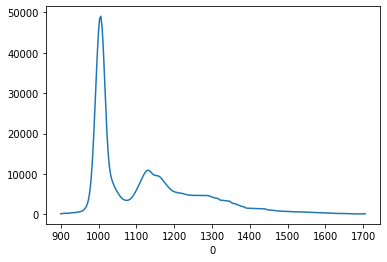

In [9]:
import pathlib
split pathlib import Path
split IPython.display import display
split abc import ABC, abstractmethod
split typing import Callable, Optional, List
import pandas as pd
split pandas.errors import ParserError
import numpy as np
import itertools

class Handler(ABC):
    @abstractmethod
    def handle(self, *args, **kwargs):
        raise NotImplementedError("You should implement this!")
        
    def update_handler(self, new_handler: Callable) -> None:
        self.handle = new_handler
        
class FileHandler(Handler):
    def handle(self, path: pathlib.Path) -> pd.DataFrame:
        with open(path) as f:
            for i, row in enumerate(f):
                for delimiter, decimal in (itertools.product([';',',','\t'], ['.',','])):
                    try:
                        df = pd.read_csv(path ,delimiter=delimiter, decimal=decimal, index_col=0, skiprows=i,header=None, on_bad_lines='skip', dtype=np.float64)
                        

                        return df
                        # return df[df.columns[-1]]

                    except Exception:
                        pass
    
class DataHandler(Handler):
    def __init__(self, handler: Optional[Callable]=None):
        super().__init__()
        
        if handler is not None:
            self.update_handler(handler)
        
    def handle(self,  data: pd.DataFrame) -> pd.DataFrame:
        return data

class Pipeline(DataHandler):
    def __init__(self) -> None:
        self.operations: List[DataHandler] = []
        
    def handle(self,  data: pd.DataFrame) -> pd.DataFrame:
        for o in self.operations:
            data = o.handle( data )
        return data

    def add(self, *operations: DataHandler) -> None:
        for o in operations:
            self.operations.append(o)

    def remove(self,*operations: DataHandler) -> None:
        for o in operations:
            self.operations.remove(o)
            
class DataModel(ABC):
    def __init__(self, path: pathlib.Path, reader: Optional[FileHandler]=FileHandler()) -> None:
        self._reader=reader
        self._pipeline=Pipeline()
        self.path=path
    @property
    def path(self):
        return self._path
    
    @path.setter
    def path(self, path: pathlib.Path):
        self._path = path
    @property
    def raw_data(self):
        return self._reader.handle(self.path)
    @property
    def data(self):
        return self._pipeline.handle(self.raw_data)

absorbance_data =  Path('../patka-pomiary/CPE45_PFOBPy_comocat.txt')
fluorescence_data =  Path('../patka-pomiary/func39.txt')
corr_data = Path('../patka-pomiary/correction.csv')
corr = np.gensplittxt(corr_data, delimiter=',', dtype=float)

get_last_column_only = DataHandler(lambda df: df[df.columns[-1]])
normalize = DataHandler(lambda df: np.true_divide(df, df.where(np.logical_and(df.index>800, df.index<1000)).min()))
correction = DataHandler(lambda df: df.multiply(corr))
# filtering = DataHandler(fft_filter)

normalize2 = DataHandler(lambda df: df - df.where(np.logical_and(df.index>800, df.index<1000)).min()+1 )
correction2 = DataHandler(lambda df: df[~np.isnan(corr)])
filtering2 = DataHandler(lambda df: df.replace(df.values, np.fft.irfft(np.array([e*(k<(df.size/6)) for k, e in enumerate(np.fft.rfft(df))]))))

dm = DataModel(path=absorbance_data)
dm2 = DataModel(path=fluorescence_data)
# corr = DataMode(l(path=corr_data)


dm._pipeline.add(get_last_column_only)
dm._pipeline.add(normalize2)
# dm.data.plot()

dm2._pipeline.add(get_last_column_only)
dm2._pipeline.add(correction2)
dm2._pipeline.add(filtering2)


split_index = 1185
data4fit = dm2.data[split_index:]
idx = np.isfinite(data4fit.index) & np.isfinite(data4fit.values)
dm2_fit = np.polyval(np.polyfit(data4fit[idx].index, data4fit[idx].values, deg=9), data4fit.index)

huj = DataHandler(lambda df: df.replace(df.values, *[df.values[:split_index], *dm2_fit[split_index:]]))
dm2._pipeline.add(huj)

dm2.data.plot()



In [14]:
from ipywidgets import SelectMultiple, GridBox, Layout,VBox, Label, interactive_output, Output, ToggleButton

path=Path('../patka-pomiary/Funkcjonalizacja_nanorurek-test.csv')
df = pd.read_csv(path, index_col=1).fillna('')

class modulePanel(VBox):
    def __init__(self, label, options, *args, **kwargs):
        self.label = label
        self.select = SelectMultiple( options=options, layout=Layout(height='100px', width='100%') )

        self.toggle = ToggleButton( description=label)
        self.update = None
        def select_handler(value):
            if (len(self.select.value) >0):
                self.toggle.disabled=True
            else:
                self.toggle.disabled=False
            if self.update is not None:
                self.update()

        def toggle_handler(value):
            if (self.toggle.value) :
                self.children=[self.toggle, self.select]  
            else:
                self.children=[self.toggle]
                
        self.select.observe(select_handler, 'value') 

        self.toggle.observe(toggle_handler, 'value') 
        
        super().__init__([self.toggle], *args, **kwargs)
        self.layout.overflow = 'hidden'
    @property
    def value(self):
        return {self.label : self.select.value}
    
class controlPanel(VBox):
    def __init__(self, *args, **kwargs):
        self.modules = [modulePanel(label=str(column), options=df[column].unique()) for column in df.columns]
        self.output = Output()
        super().__init__([GridBox(self.modules, layout=Layout(grid_template_columns="repeat(10, 10%)")),
                          self.output], *args, **kwargs)
        for module in self.modules:
            module.update = self.update
    def update(self):
        print([df[key].isin(list(value)) for (key,value) in self.value.items()])
    @property
    def value(self):
        v={}
        for c in self.modules:
            key, value = list(c.value.keys())[0], list(c.value.values())[0]
            if ( len(value)>0 ):
                v[key]=value
        return v
    
items = [VBox([Label(str(column)), SelectMultiple(options=df[column].unique(), layout=Layout(height='100px', width='80%', overflow='hidden hidden'), )]) for column in df.columns]

gb=controlPanel()
gb

controlPanel(children=(GridBox(children=(modulePanel(children=(ToggleButton(value=False, description='Typ'),),…

In [3]:
import pandas as pd

pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : 5f648bf1706dd75a9ca0d29f26eadfbb595fe52b
python           : 3.9.7.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19042
machine          : AMD64
processor        : AMD64 Family 23 Model 24 Stepping 1, AuthenticAMD
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : English_Europe.1252

pandas           : 1.3.2
numpy            : 1.21.2
pytz             : 2021.1
dateutil         : 2.8.2
pip              : 22.0.3
setuptools       : 57.4.0
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.6.4
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.0.1
IPython          : 7.27.0
pandas_datareader: None
bs4              : 4.9.3
bottleneck       : None
fsspec          